In [2]:
import socket
import json
import ast
from datetime import datetime
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from fipa_acl import create_fipa_acl_message, parse_fipa_acl_message
from sklearn import metrics
import threading



In [4]:
df = pd.read_csv(r'.\WindTrain.csv', parse_dates=['Date'])
df = df.dropna()
#target = df['Power']
# --------------------- 1. Estructura de los datos --------------------- #
df = df.dropna()

In [5]:

#check if the 'Date' column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'])

#check null values
if df.isnull().values.any():
    print("Data contains null values. Please clean the data before proceeding.")   


C:\Users\Usuario\AppData\Local\Temp\ipykernel_19136\3455450117.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


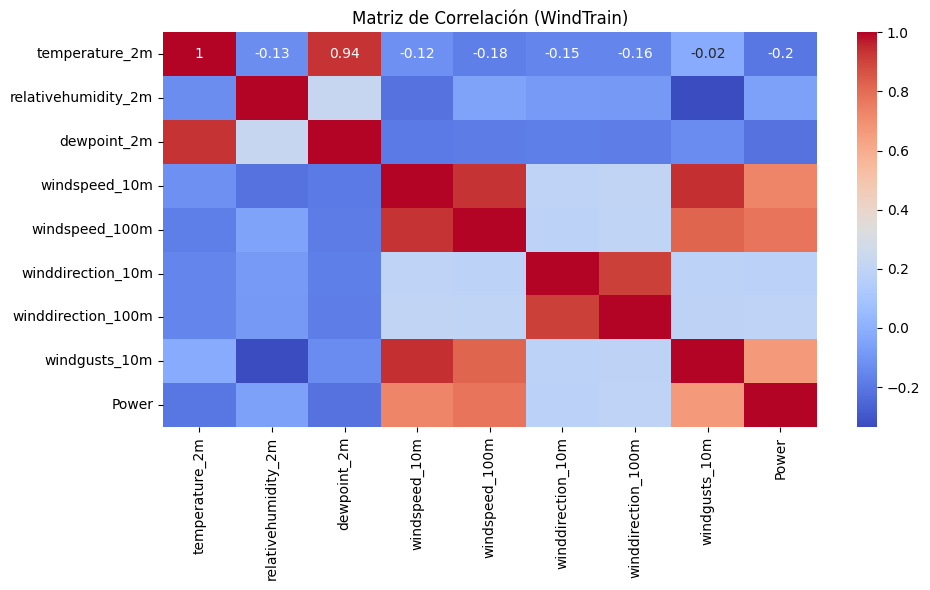

Index(['Date', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power'],
      dtype='object')
                   Feature         VIF
0       VIF_temperature_2m   76.990499
1  VIF_relativehumidity_2m   13.346208
2          VIF_dewpoint_2m   71.730895
3        VIF_windspeed_10m  152.255181
4       VIF_windspeed_100m   71.231152
5    VIF_winddirection_10m   30.221729
6   VIF_winddirection_100m   29.794272
7        VIF_windgusts_10m   64.395262


In [6]:

# Correlation heat‑map
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (WindTrain)')
plt.tight_layout()
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()

print(df.columns)

# Chequeamos si existe multicolinealidad
X_full = df.drop(columns=['Date', 'Power'])  # all candidate predictors except target variable
# VIF (Variance Inflation Factor)
vif = pd.DataFrame()
vif['Feature'] = X_full.columns
vif['VIF'] = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
# Añadir el nombre de la columna a los valores de VIF
vif['Feature'] = vif['Feature'].apply(lambda x: f"VIF_{x}")
# Mostrar el DataFrame de VIF
print(vif)


In [7]:

#Start to drop the variables with high VIF, we start with the  highest one: VIF_windspeed_10m
# The criteria usually used is VIF <= 10
cols_to_drop = ['windspeed_10m','dewpoint_2m','winddirection_10m','windspeed_100m']
X_reduced = X_full.drop(columns=cols_to_drop)
# Check the VIF again
vif_reduced = pd.DataFrame()
vif_reduced['Feature'] = X_reduced.columns
vif_reduced['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
print(vif_reduced)


               Feature       VIF
0       temperature_2m  5.407869
1  relativehumidity_2m  7.213723
2   winddirection_100m  4.915317
3        windgusts_10m  4.961921


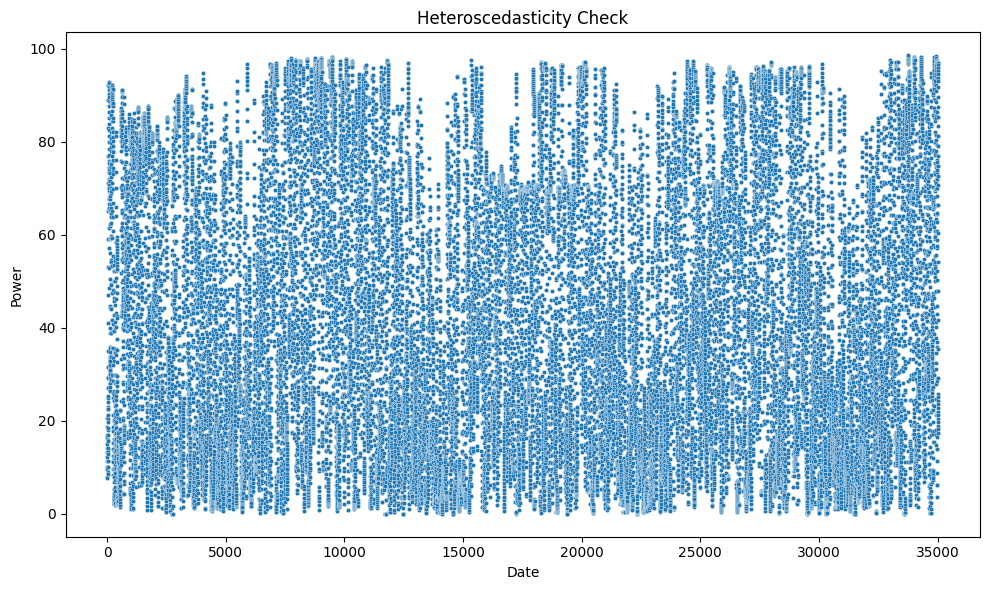

White's LM statistic : 1974.90
White's test p-value : 0.0000
White's F statistic  : 47.50
White's F p-value    : 0.0000


In [8]:

#guarda el df las variables seleccionadas
selected_features = list(X_full.columns)
# Guardar en un dataframe las variables seleccionadas
df_selected = pd.DataFrame(selected_features, columns=['Selected Features'])

#usa de df las variables seleccionadas, Power y Date
df = df[['Date', 'Power'] + selected_features]

#Check heteroscedasticity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['Power'], s=10)
plt.title('Heteroscedasticity Check')
plt.xlabel('Date')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

# White's test for heteroscedasticity
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

# 1Build the design matrix with an intercept
X   = sm.add_constant(df[selected_features])   # adds the constant as the first column
y   = df['Power']

# Fit the OLS model and obtain residuals
ols_results = sm.OLS(y, X).fit()
resid       = ols_results.resid

# Run White’s test
#     exog must be exactly the same matrix (including the constant) that you used in the regression
white_test = het_white(resid, X)

lm_stat, p_value, f_stat, f_p_value = white_test
print(f"White's LM statistic : {lm_stat:.2f}")
print(f"White's test p-value : {p_value:.4f}")
print(f"White's F statistic  : {f_stat:.2f}")
print(f"White's F p-value    : {f_p_value:.4f}")


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2218.3858471652493, tolerance: 1830.7812235977908
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2085.540975254029, tolerance: 1830.7812235977908
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1861.1733527015895, tolerance: 1830.7812235977908
  model = cd_fast.enet_coordinate_descent

Lasso Regression - RMSE: 17.69, R²: 0.612
Ridge Regression - RMSE: 17.69, R²: 0.612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 8
[LightGBM] [Info] Start training from score 40.642157
LightGBM Regression - RMSE: 15.29, R²: 0.710


<Figure size 1200x600 with 0 Axes>

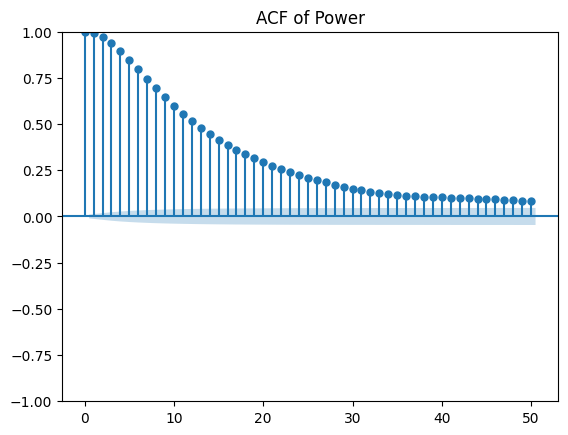

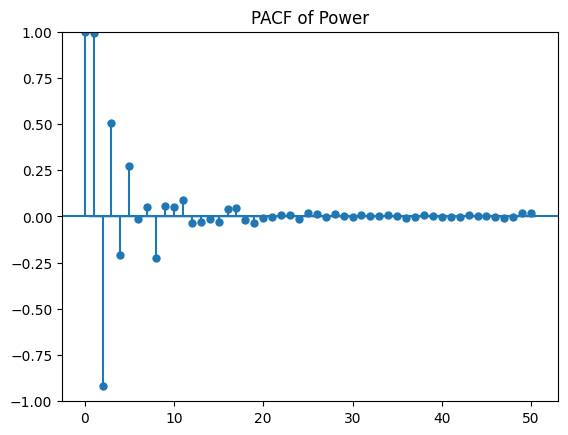

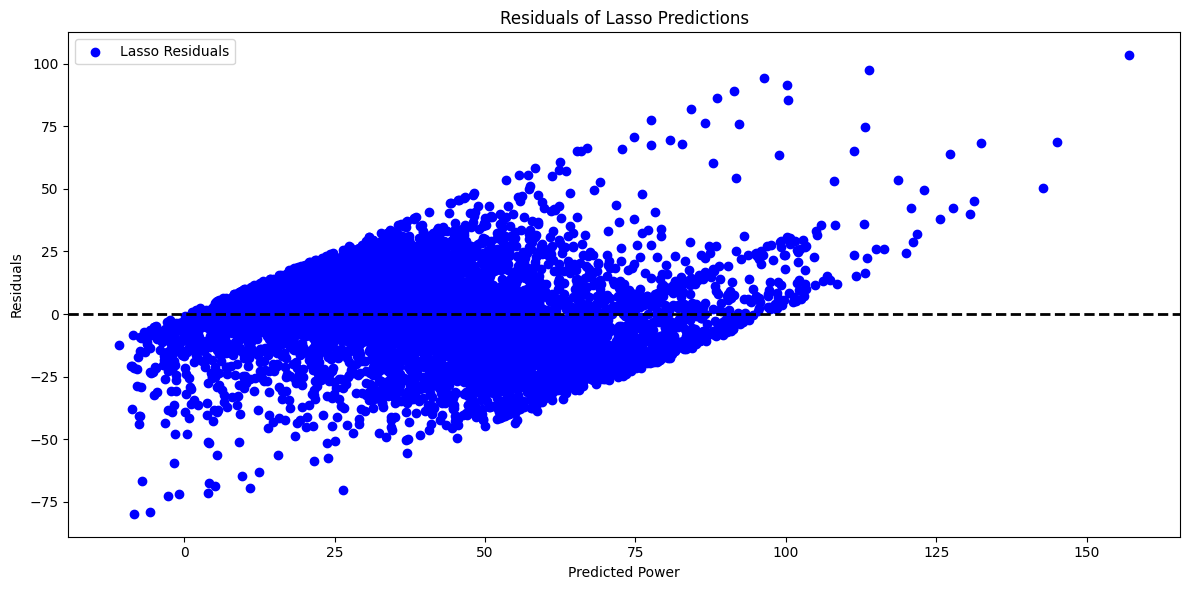

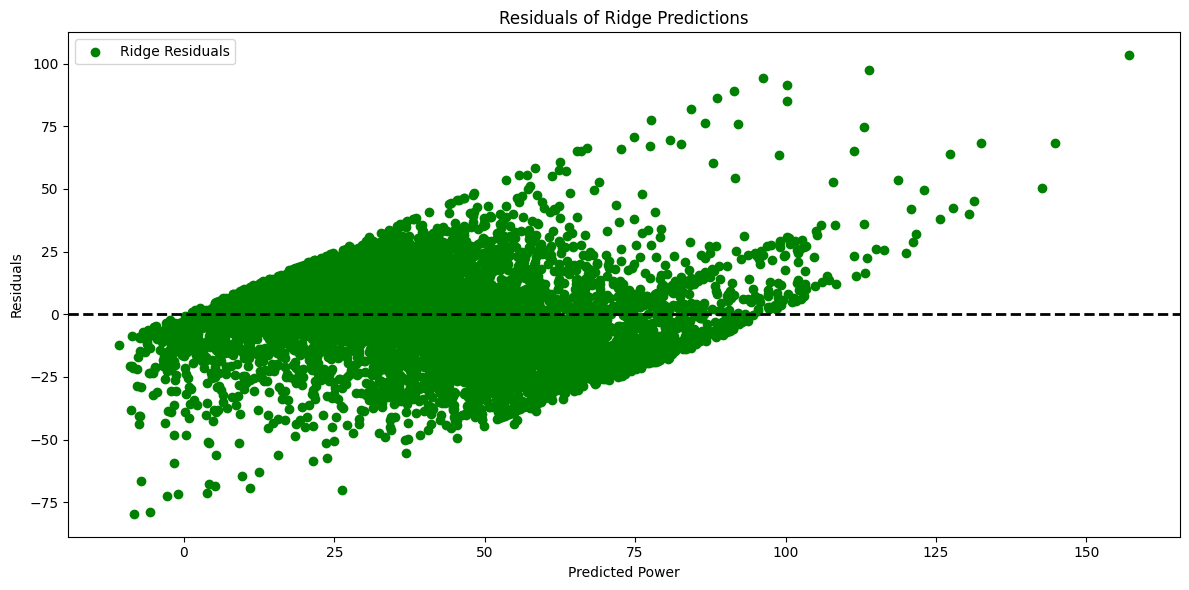

In [9]:

#Time Series Analysis

# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plot_acf(df['Power'], lags=50, title='ACF of Power')
plot_pacf(df['Power'], lags=50, title='PACF of Power')
plt.savefig('acf_pacf_power.png')


# Modelos de predicción
# Dividimos el dataset en train y test
# divide un train and validadion set
#x_train y y_train es el train set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV

# Split the data into features and target variable
X_full = df[selected_features]
y = df['Power']  # target variable

X_train, X_val, y_train, y_val = train_test_split(X_full, y, test_size=0.2, random_state=42)
# Lasso Regression
from sklearn.linear_model import LassoCV, RidgeCV
lasso_model = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso_model.fit(X_train, y_train)
# Evaluate Lasso
lasso_val_pred = lasso_model.predict(X_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val, lasso_val_pred))
lasso_r2 = r2_score(y_val, lasso_val_pred)
print(f"Lasso Regression - RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.3f}")
# Ridge Regression
ridge_model = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=5)
ridge_model.fit(X_train, y_train)
# Evaluate Ridge
ridge_val_pred = ridge_model.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_val_pred))
ridge_r2 = r2_score(y_val, ridge_val_pred)
print(f"Ridge Regression - RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.3f}")
# LightGBM Regression
from lightgbm import LGBMRegressor
params = {
    "learning_rate": 0.2,
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": 10,
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# Evaluate LightGBM
lgbm_val_pred = lgbm_model.predict(X_val)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_val_pred))
lgbm_r2 = r2_score(y_val, lgbm_val_pred)
print(f"LightGBM Regression - RMSE: {lgbm_rmse:.2f}, R²: {lgbm_r2:.3f}")
# Plot residuals for Lasso
plt.figure(figsize=(12, 6))
plt.scatter(lasso_val_pred, lasso_val_pred - y_val, c='blue', marker='o', label='Lasso Residuals')
plt.xlabel('Predicted Power')
plt.ylabel('Residuals')
plt.title('Residuals of Lasso Predictions')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.legend()
plt.tight_layout()
plt.show()

# Plot residuals for Ridge
plt.figure(figsize=(12, 6))
plt.scatter(ridge_val_pred, ridge_val_pred - y_val, c='green', marker='o', label='Ridge Residuals')
plt.xlabel('Predicted Power')
plt.ylabel('Residuals')
plt.title('Residuals of Ridge Predictions')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.legend()
plt.tight_layout()
plt.show()


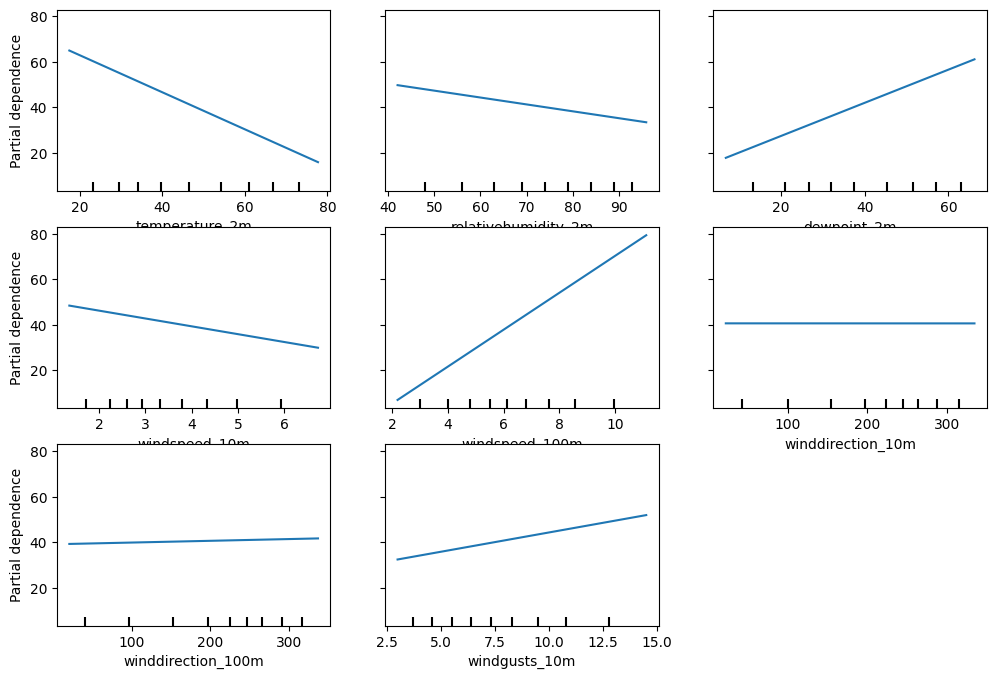

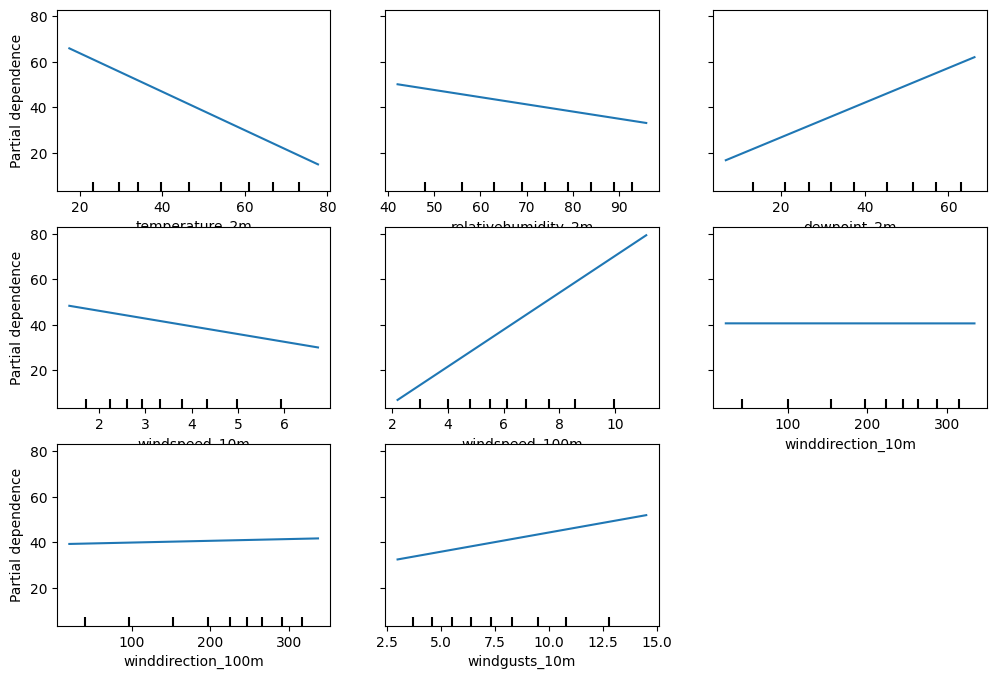

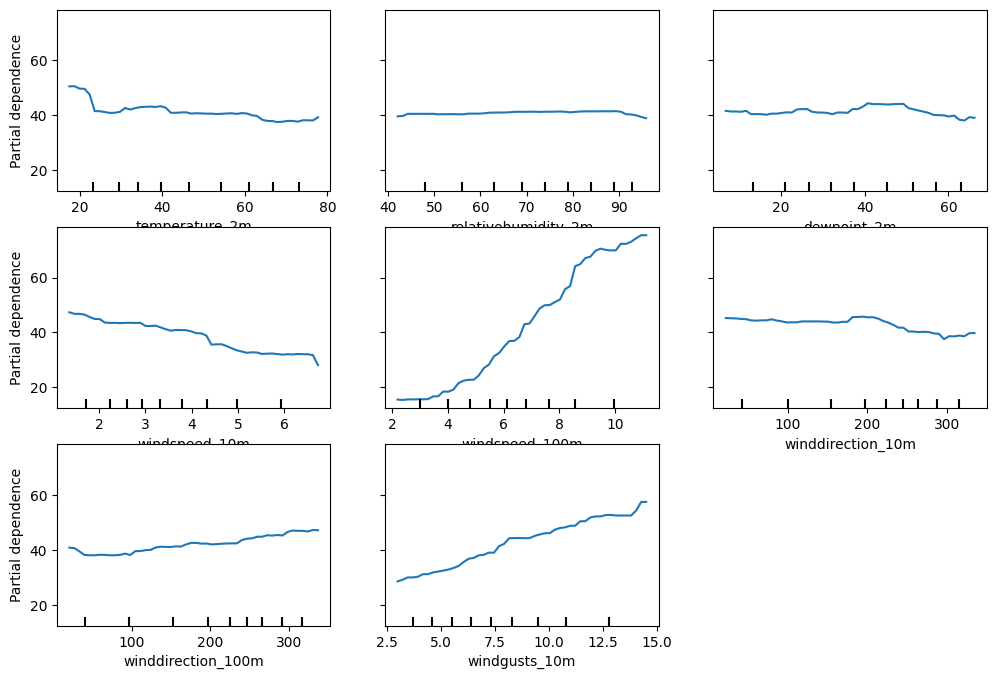

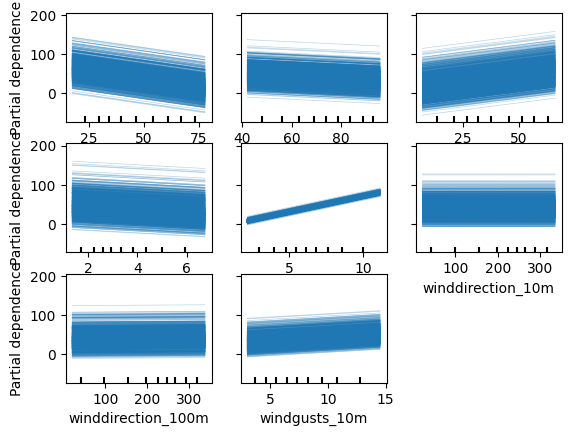

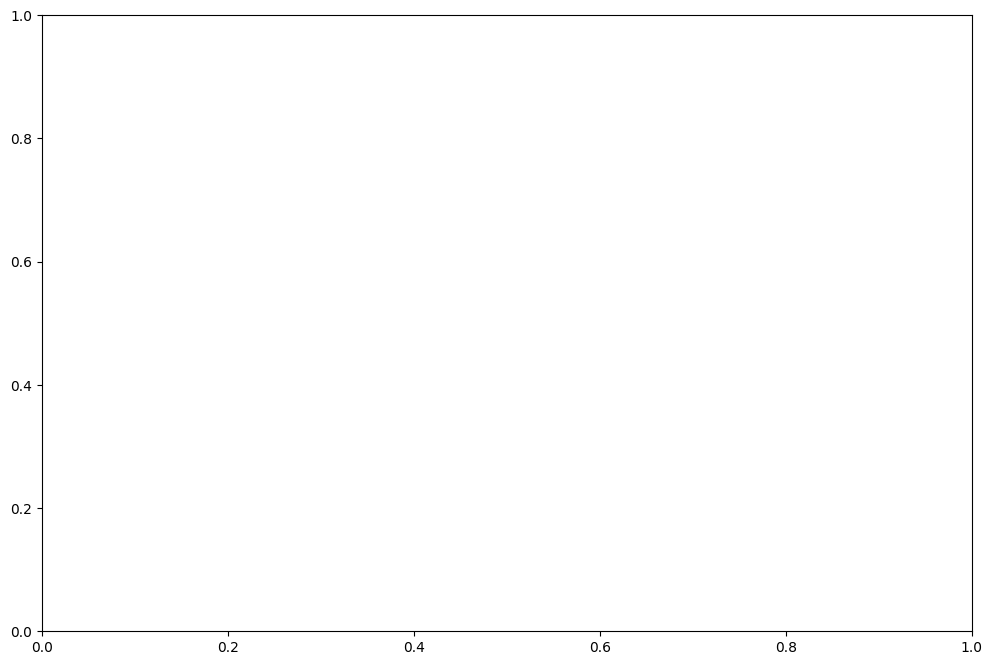

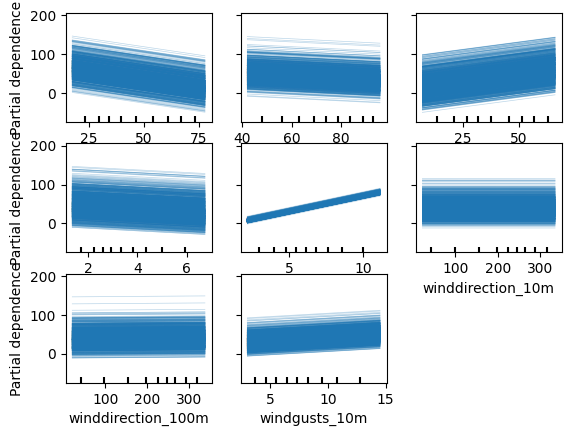

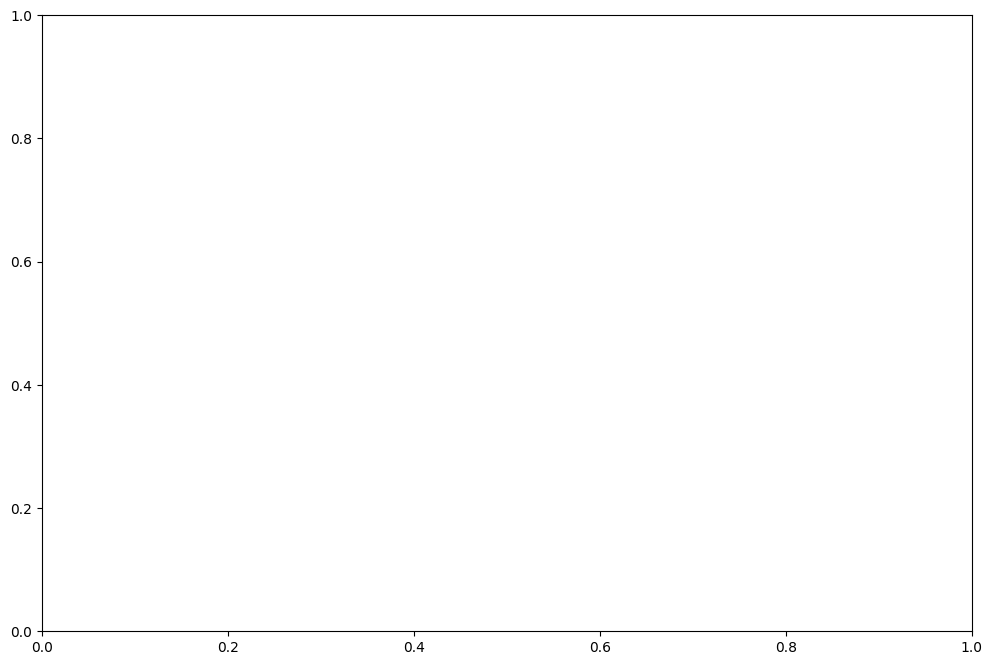

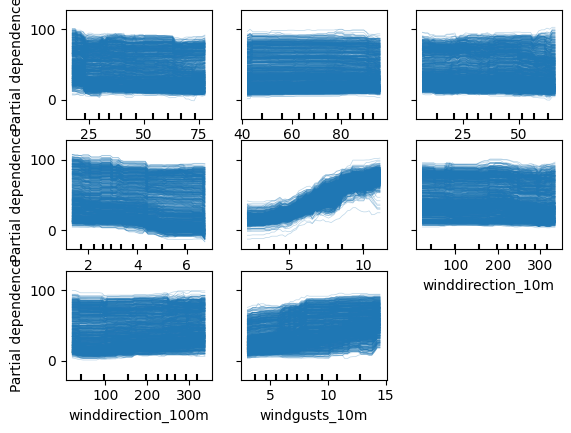

In [10]:
import warnings
warnings.filterwarnings("ignore")

# ---- xAI ----# Empezamos por la explicabilidad de los modelos Ridge y Lasso
# Modelos Globales: PDP (Partial Dependence Plots), ADP (Accumulated Dependence Plots) y ICE (Individual Conditional Expectation)
# Plot Partial Dependence for Lasso
from sklearn.inspection import PartialDependenceDisplay
# Plot Partial Dependence for Lasso
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# ICE (Individual Conditional Expectation) plots for Lasso
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)


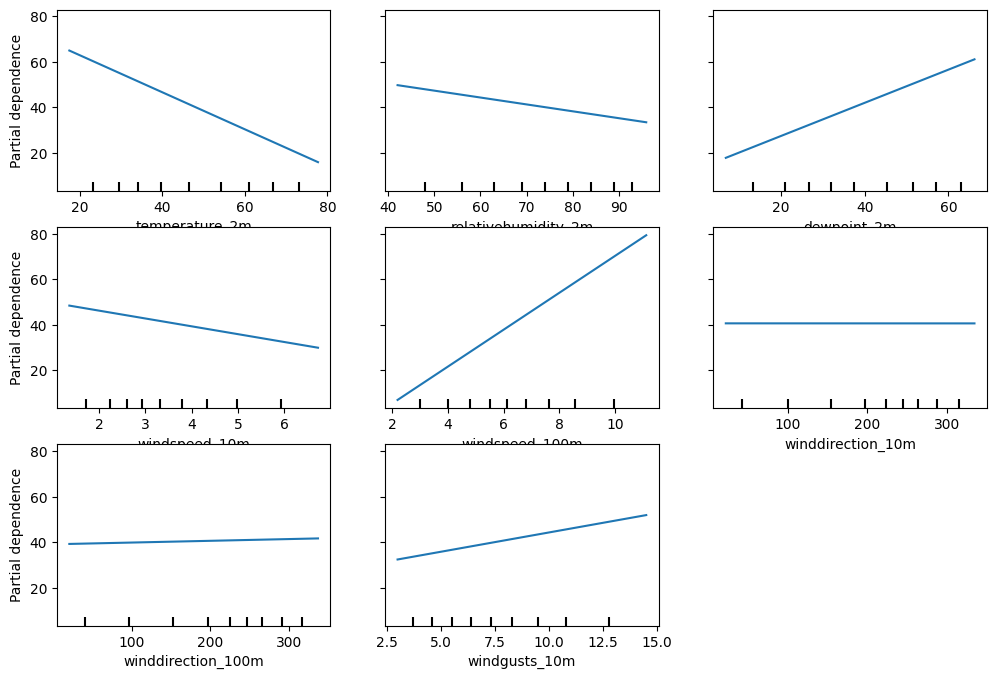

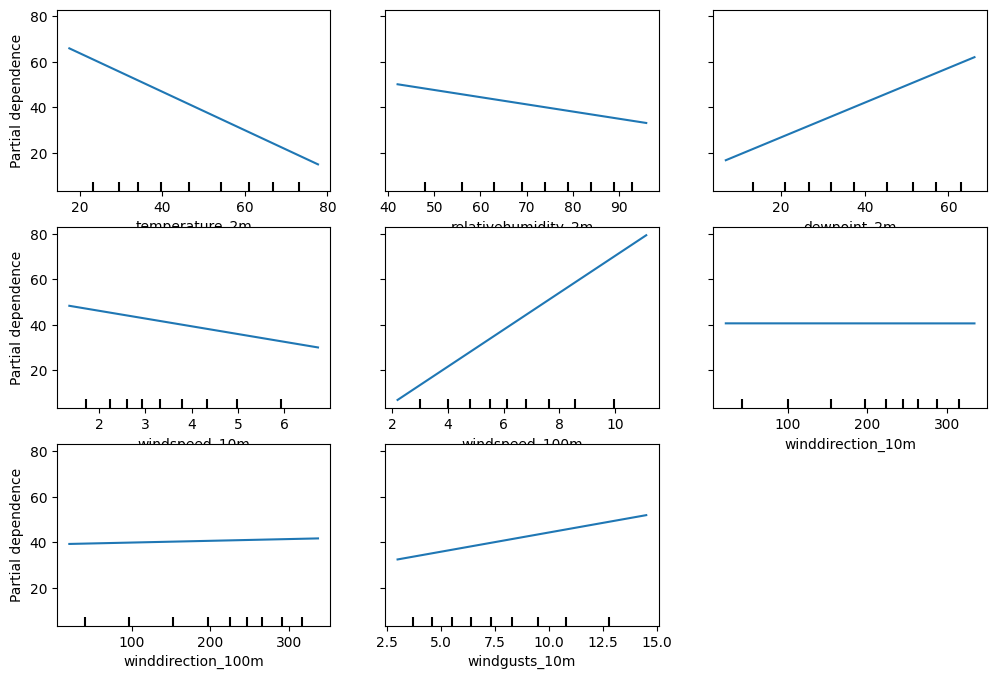

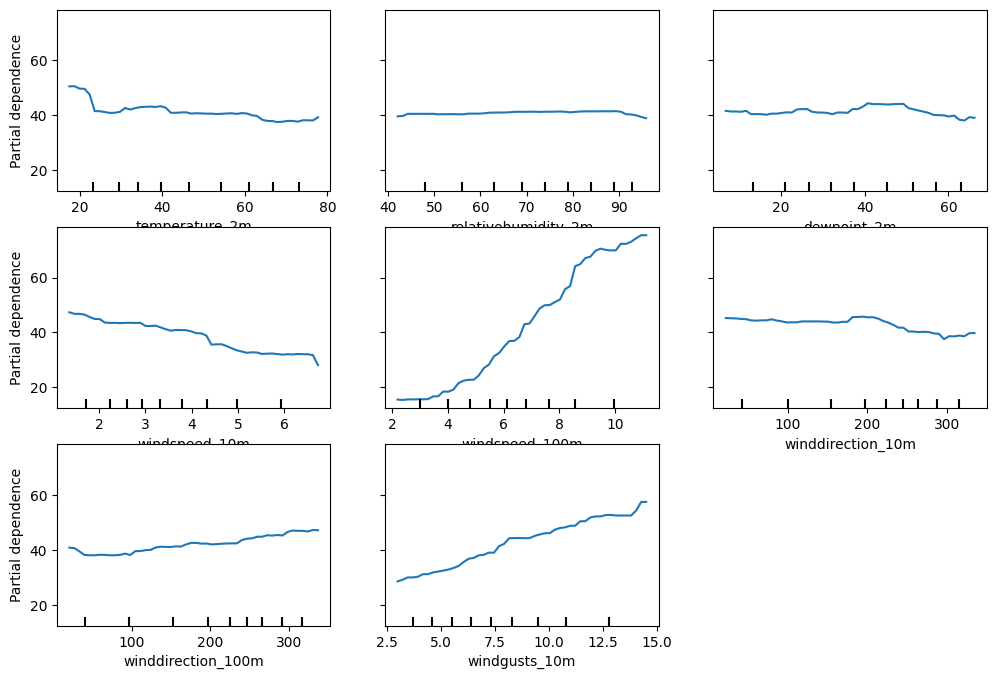

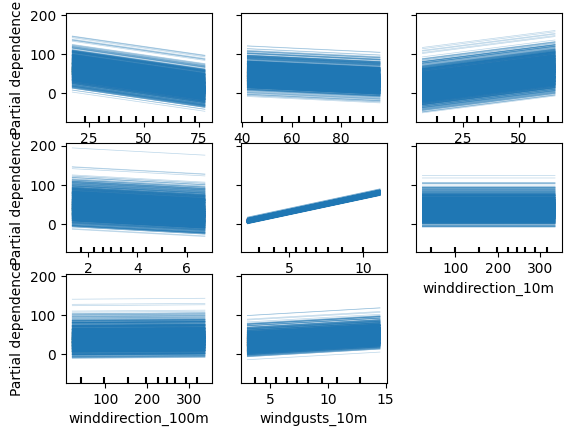

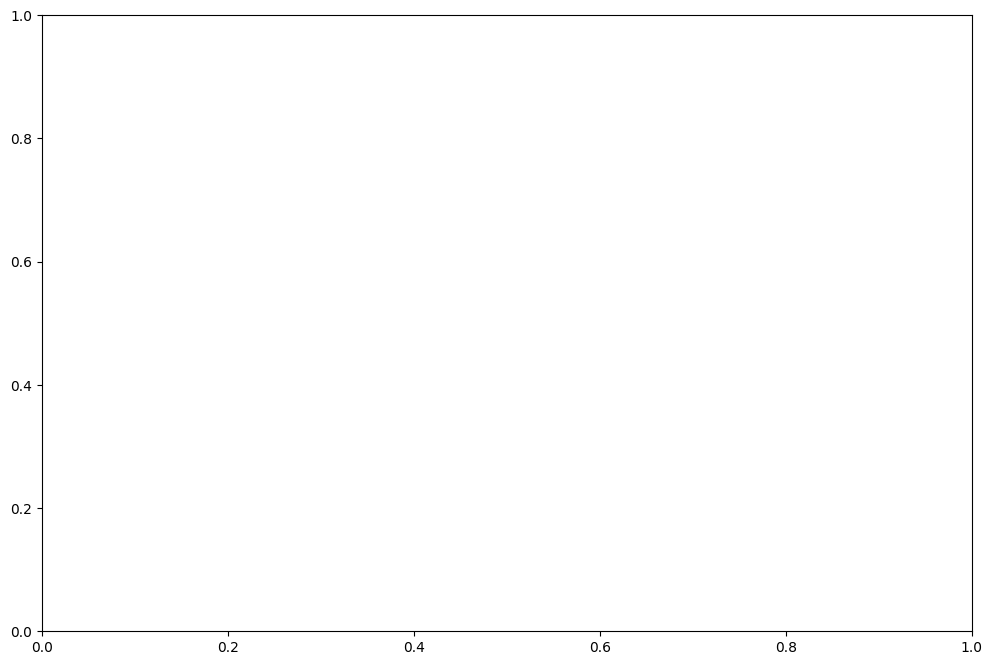

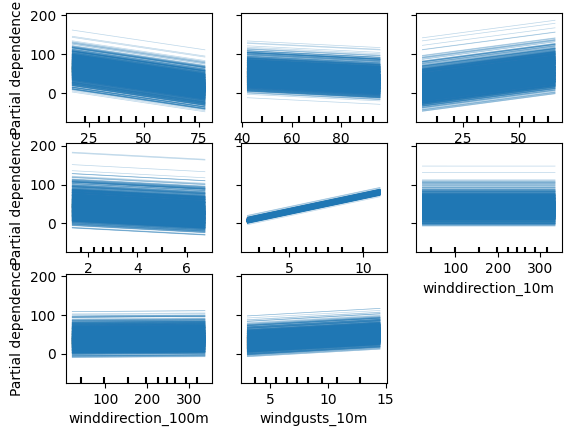

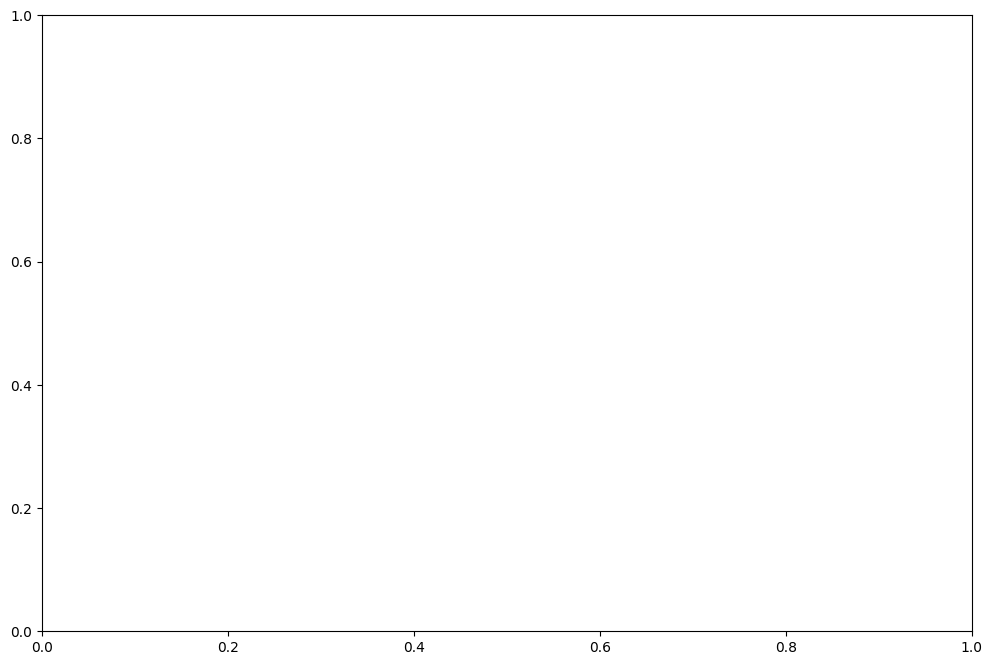

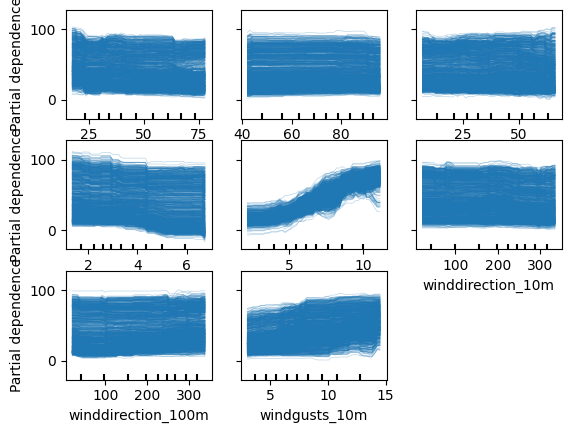

In [11]:

#----xAI----
import warnings
warnings.filterwarnings("ignore")

#Empezamos por la explicabilidad de los modelos Ridge y Lasso
# Modelos Globales: PDP (Partial Dependence Plots), ADP (Accumulated Dependence Plots) y ICE (Individual Conditional Expectation)
# Plot Partial Dependence for Lasso
from sklearn.inspection import PartialDependenceDisplay
# Plot Partial Dependence for Lasso
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# ICE (Individual Conditional Expectation) plots for Lasso
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)


In [32]:
!pip install --pre --upgrade "numba>=0.60.0.dev0" "llvmlite>=0.46.0.dev0"


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


ERROR: Ignored the following versions that require a different python version: 0.36.0 Requires-Python >=3.6,<3.10; 0.37.0 Requires-Python >=3.7,<3.10; 0.38.0 Requires-Python >=3.7,<3.11; 0.38.1 Requires-Python >=3.7,<3.11; 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10; 0.55.0 Requires-Python >=3.7,<3.11; 0.55.0rc1 Requires-Python >=3.7,<3.11; 0.55.1 Requires-Python >=3.7,<3.11; 0.55.2 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement llvmlite>=0.46.0.dev0 (from versions: 0.2.0, 0.2.1, 0.2.2, 0.4.0, 0.5.0, 0.6.0, 0.7.0, 0.8.0, 0.9.0, 0.10.0, 0.11.0, 0.12.0.1, 0.12.1, 0.13.0, 0.14.0,

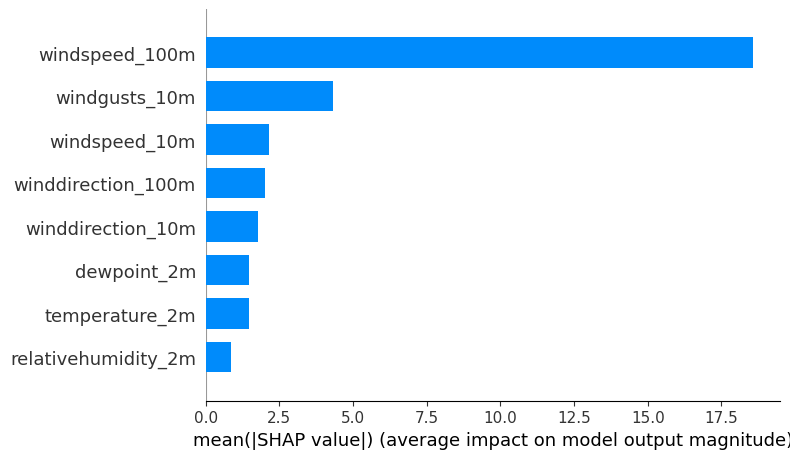

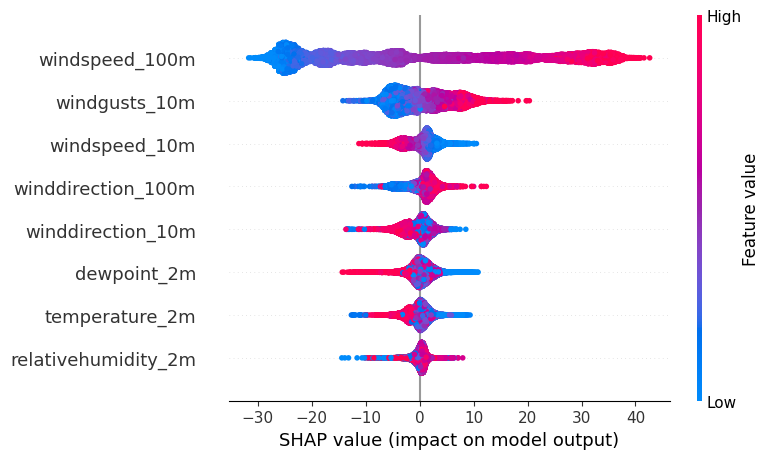

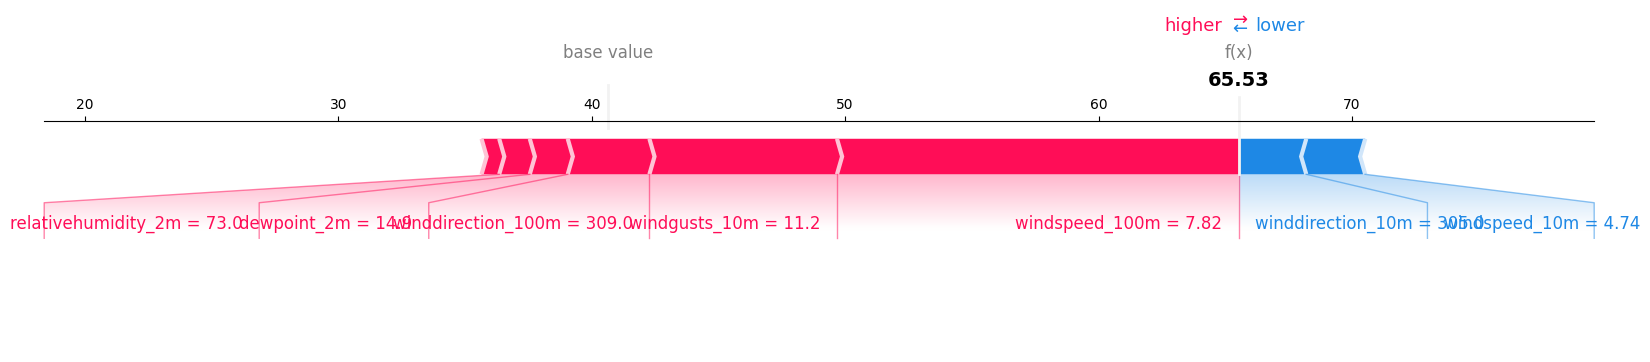

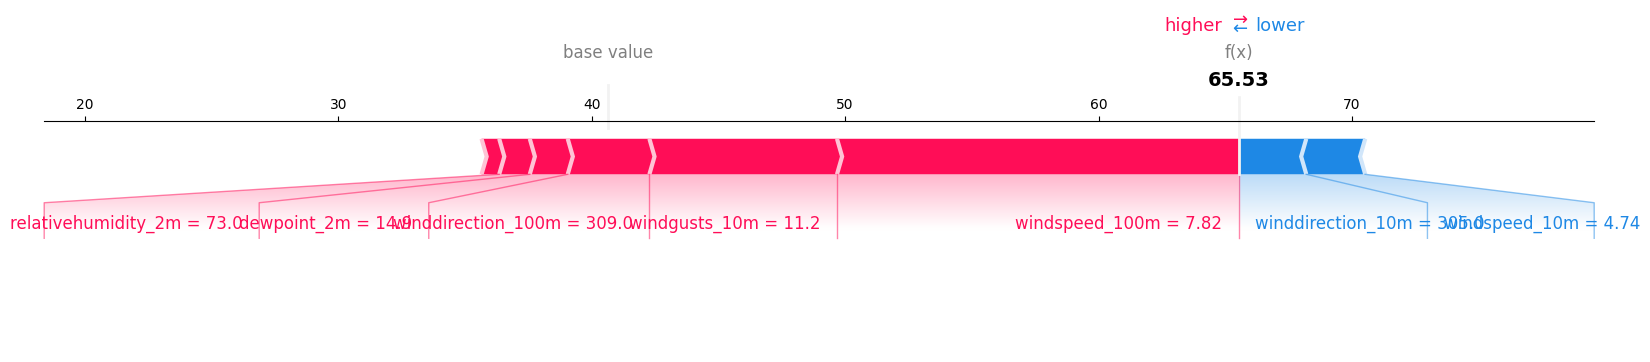

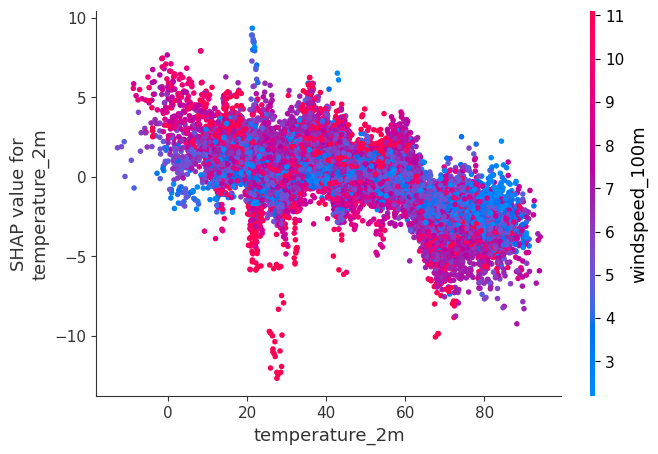

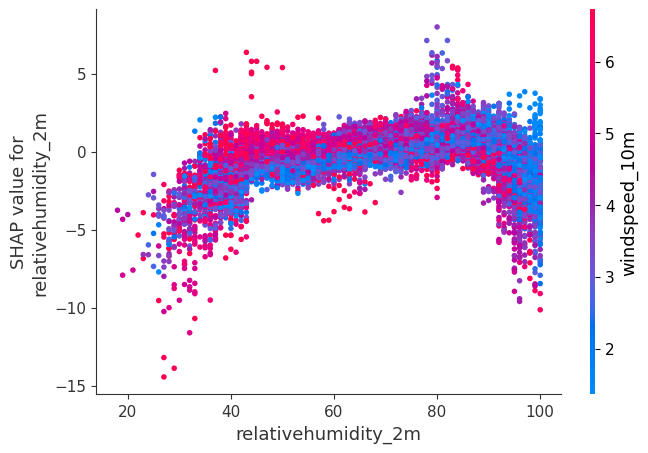

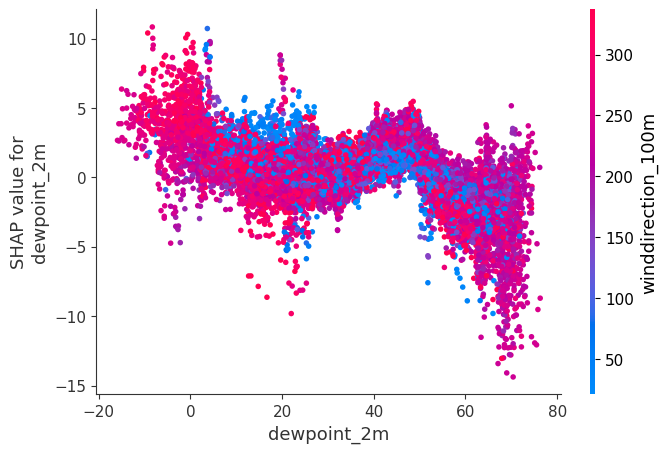

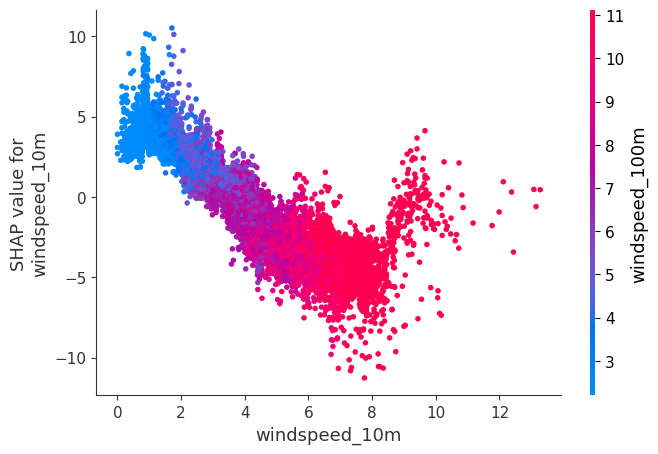

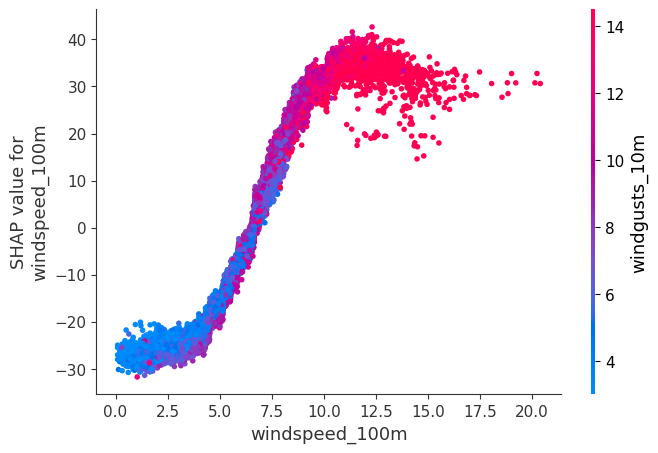

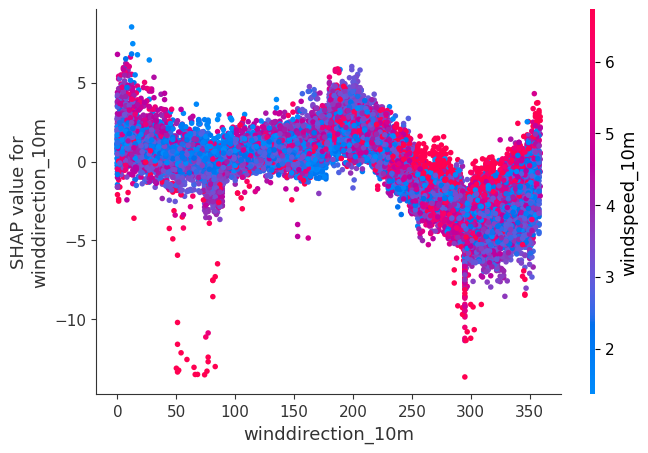

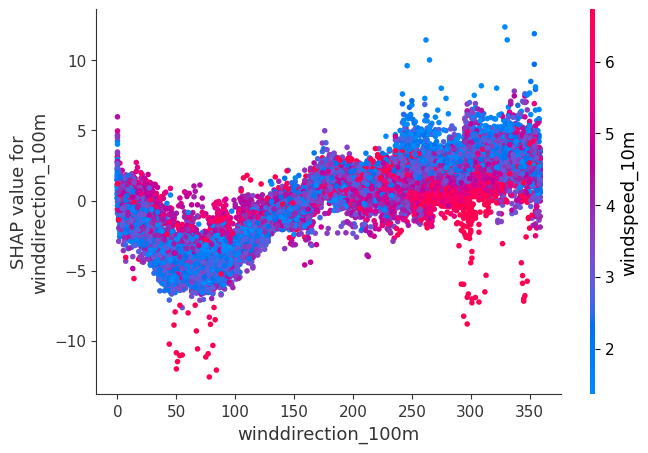

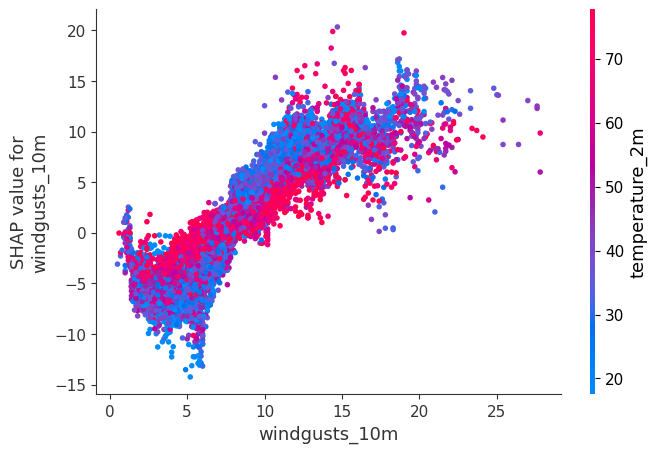

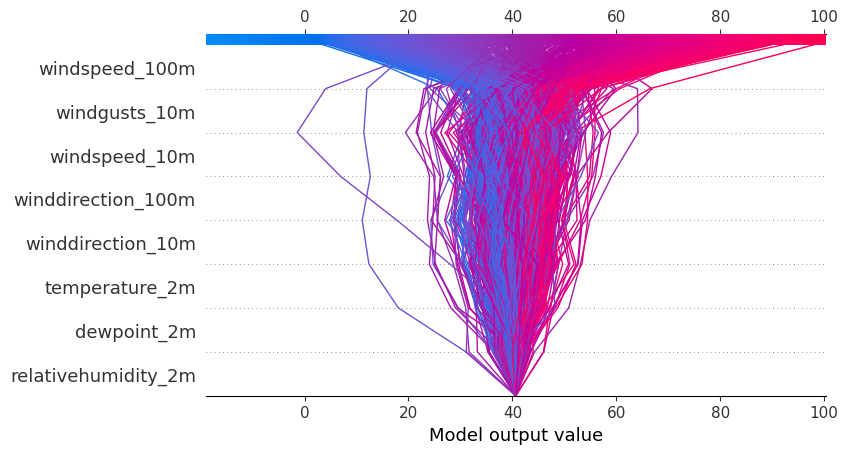

In [12]:

# ------ Local Explanations with SHAP, LIME and Ceteris Paribus ------ Agnostic models: SHAP (SHapley Additive exPlanations)
import shap
shap.initjs()

# 1 Create explainer
explainer    = shap.TreeExplainer(lgbm_model)

# 2 Compute SHAP values once
shap_values  = explainer.shap_values(X_train)

# ── Global views ──────────────────────────────────────────
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

# ── Local force plot ──────────────────────────────────────
row = 0                       # choose the row you want to explain
if isinstance(shap_values, list):          # multi-class
    class_id     = 2                      # pick the class to display
    base_value   = explainer.expected_value[class_id]
    row_shap     = shap_values[class_id][row, :]
else:                                      # regression or single-output
    base_value   = explainer.expected_value
    row_shap     = shap_values[row, :]

shap.force_plot(
    base_value,            # ← NEW first argument in v0.20+
    row_shap,              # SHAP vector for the chosen instance
    X_train.iloc[row, :],  # feature values for that instance
    matplotlib=True        # set False for the interactive JS view
)

shap.force_plot(
    base_value,            # ← NEW first argument in v0.20+
    row_shap,              # SHAP vector for the chosen instance
    X_train.iloc[row, :],  # feature values for that instance
    matplotlib=True        # set False for the interactive JS view
)


# Plot SHAP values for specific features, haz un bucle de las variables seleccionadas
# ── dependence plots for the features you picked ───
for feature in selected_features:
    # single-output regression / binary classification
    shap.dependence_plot(feature,
                         shap_values,         # ← NOT explainer
                         X_train)

# ── dependence plots for the features you picked ───
import numpy as np
n_show   = 1000
idx      = np.random.choice(X_train.shape[0], n_show, replace=False)

shap.decision_plot(
    base_value,
    shap_values[idx],
    X_train.iloc[idx],
    link='identity'
)

# ── choose how many rows you want to display in the force plot ──
n_show = 1_000           # or any smaller number that renders quickly

# single-output regression / binary classification
if isinstance(shap_values, np.ndarray):
    shap.force_plot(
        explainer.expected_value,     # base value
        shap_values[:n_show, :],      # NO “.values” here
        X_train.iloc[:n_show, :],
        matplotlib=False              # interactive JS view (omit for Jupyter)
    )

# multi-class example → pick one class to visualise
else:                                 # shap_values is a list
    class_id = 0                      # the class you want to show
    shap.force_plot(
        explainer.expected_value[class_id],
        shap_values[class_id][:n_show, :],
        X_train.iloc[:n_show, :],
        matplotlib=False
    )
shap.force_plot(explainer.expected_value, shap_values[:n_show, :], X_train.iloc[:n_show, :], matplotlib=False)


 99%|===================| 27846/28032 [01:53<00:00]        

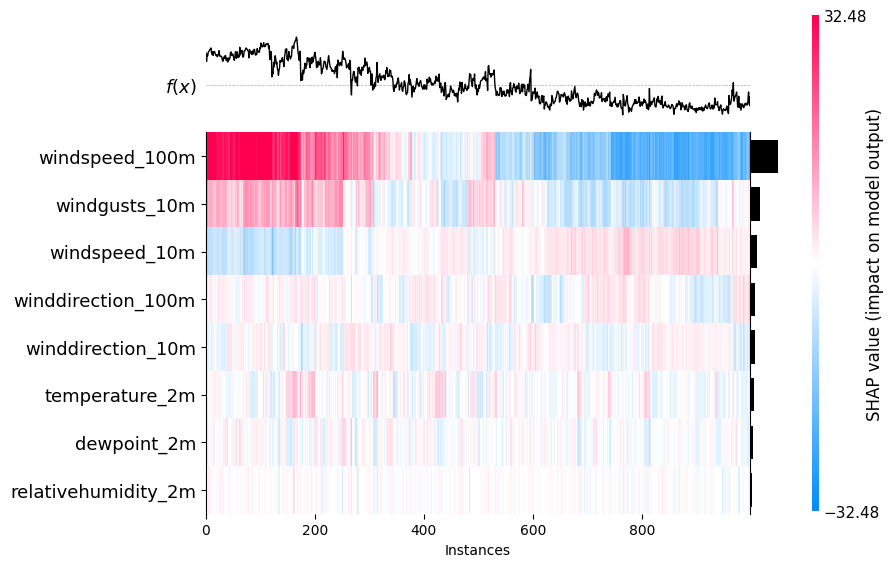

<Axes: xlabel='Instances'>

In [14]:
import shap
explain = shap.Explainer(lgbm_model, X_train)
shap_values = explain(X_train)
shap.plots.heatmap(shap_values[:1000] )

In [15]:
from IPython.display import IFrame
IFrame("outputs/lime_explanation.html", width=1000, height=500)

In [ ]:
# LIME (Local Interpretable Model‑agnostic Explanations)
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data         = X_train.values,
    feature_names         = X_train.columns.tolist(),
    mode                  = 'regression',
    discretize_continuous = True
)

row_id = 2940
explanation = explainer_lime.explain_instance(
    data_row     = X_val.iloc[row_id].values,
    predict_fn   = lgbm_model.predict,
    num_features = X_train.shape[1]
)


#explanation.show_in_notebook(show_table=True, show_all=False)
display(HTML(explanation.as_html()))


In [1]:
# 1️⃣  Explainer que GENERE el vecindario justo alrededor de la fila
explainer_lime = LimeTabularExplainer(
    training_data          = X_train.values,
    feature_names          = X_train.columns.tolist(),
    mode                   = 'regression',
    discretize_continuous  = True,
    sample_around_instance = True   # <— centra las perturbaciones en la fila
)

# 2️⃣  Pide la explicación con MUCHAS muestras sintéticas
row_id = 2940
explanation = explainer_lime.explain_instance(
    data_row     = X_val.iloc[row_id].values,
    predict_fn   = lgbm_model.predict,
    num_features = 10,
    num_samples  = 10_000,   # ← tamaño del vecindario
    kernel_width = 3         # ← radio: +grande = +lejos
)

# 3️⃣  Extrae las perturbaciones y sus predicciones
X_pert   = explanation.neighborhood_data     # (10 000 × n_features)
y_pert   = explanation.neighborhood_labels   # vector con ŷ del modelo
weights  = explanation.neighborhood_weights  # pesos kernel

# 4️⃣  Ejemplo rápido: ver la dispersión de las ŷ
import matplotlib.pyplot as plt
plt.hist(y_pert, bins=50)
plt.title("Distribución de predicciones en el vecindario LIME")
plt.show()



NameError: name 'LimeTabularExplainer' is not defined

In [44]:
!pip install --upgrade nbformat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [45]:
import dalex as dx

# Create a DALEX explainer
explainer = dx.Explainer(
    model=lgbm_model,
    data=X_train,
    y=y_train,
    label="LightGBM Model - FV Module"
)

pfi = explainer.model_parts(loss_function='rmse')
pfi.plot(max_vars=25)

# Partial dependence plots (PDP) con dalex

###  (ya tienes `explainer` definido)  ###
vars_to_check = selected_features[:5]          # primeras 5 por claridad

pdp = explainer.model_profile(
        variables     = vars_to_check,
        type          = "partial",
        variable_type = "numerical")

pdp.plot(title="PDP – LightGBM – FV Module")


# otro explainer para el modelo de Ridge
ridge_exp = dx.Explainer(ridge_model, X_train, y_train, label="Ridge")
lasso_exp = dx.Explainer(lasso_model, X_train, y_train, label="Lasso")
# PDP de la misma(s) variable(s)
pdp_lgbm  = explainer.model_profile(
                variables     = vars_to_check,   # <─ lista de variables
                type          = "partial",       # PDP
                variable_type = "numerical"      # opcional
)

pdp_ridge = ridge_exp.model_profile(

                variables     = vars_to_check,
                type          = "partial",
                variable_type = "numerical"
)
pdp_lasso = lasso_exp.model_profile(

                variables     = vars_to_check,
                type          = "partial",
                variable_type = "numerical"
)

pdp_ridge.plot(title="PDP – Ridge – FV Module")
pdp_lasso.plot(title="PDP – Lasso – FV Module")

# Accumulated Local Effects (ALE) plots
# ── 2. Calcular los perfiles ALE ─────────────────────────────────
ale_lgbm = explainer.model_profile(
              variables     = None,        # lista o str
              type          = "accumulated",   # ← la clave
              variable_type = "numerical",     # o "categorical"
              span          = 0.25,            # suavizado (opc.)
              center        = True             # centra en ŷ media
)

# ── 3. Visualizar ────────────────────────────────────────────────
ale_lgbm.plot(title="Accumulated Local Effects – LightGBM")

# Para comparar con otro modelo:
ridge_exp  = dx.Explainer(ridge_model, X_train, y_train, label="Ridge")
ale_ridge  = ridge_exp.model_profile(variables=None, type="accumulated")
ale_lgbm.plot(ale_ridge)      # dos curvas en la misma figura




Preparation of a new explainer is initiated

  -> data              : 28032 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28032 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : LightGBM Model - FV Module
  -> predict function  : <function yhat_default at 0x000002B4816A7880> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.32, mean = 40.6, max = 99.5
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -72.5, mean = 3.2e-10, max = 64.2
  -> model_info        : package lightgbm

A new explainer has been created!


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Par-par: 100%|██████████| 28/28 [01:30<00:00,  3.25s/it]


Top-10 interacciones según H-stat:
 relativehumidity_2m  windspeed_10m          1.041880
dewpoint_2m          windspeed_10m          1.024476
temperature_2m       windspeed_10m          1.022631
windspeed_10m        winddirection_100m     1.011848
winddirection_10m    winddirection_100m     1.006386
temperature_2m       dewpoint_2m            1.001803
windspeed_10m        windgusts_10m          0.994476
                     winddirection_10m      0.986982
relativehumidity_2m  dewpoint_2m            0.985683
temperature_2m       relativehumidity_2m    0.980096
dtype: float64


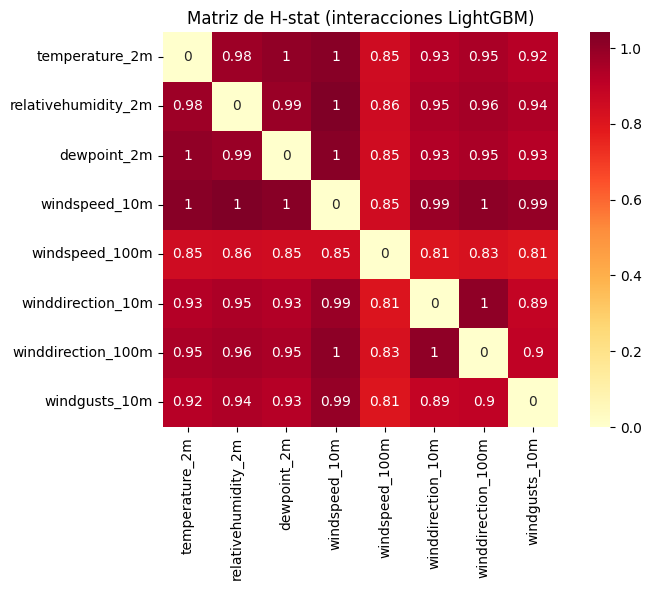

In [46]:
# Overall H-stat: This gives the percentage of the features effect on the predictions that come from the interactions with all other features.
# ------------------------------------------------------------
# 1. Imports y función para el H-stat emparejado (versión índices)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.inspection import partial_dependence
from tqdm import tqdm

def pairwise_h_stat(model, X, features=None, grid=20, sample=5000, verbose=True):
    """
    Friedman & Popescu Pairwise H-statistic usando índices de columna.
    """
    if features is None:
        features = X.columns.tolist()

    # Mapeo nombre → índice
    idx_map = {name: i for i, name in enumerate(X.columns)}
    feat_idx = [idx_map[f] for f in features]

    # Muestreo opcional para acelerar
    X_int = X.sample(sample, random_state=0) if sample and len(X) > sample else X

    # PDP univariante (por índice)
    pd_uni = {}
    for fi, fname in zip(feat_idx, features):
        res = partial_dependence(model, X_int, [fi],
                                 grid_resolution=grid, kind="average")
        pd_uni[fname] = res["average"][0].ravel()   # (g,)

    # Matriz H vacía
    h_mat = pd.DataFrame(np.zeros((len(features), len(features))),
                         index=features, columns=features)

    # Cálculo par-par (índices)
    iterator = combinations(range(len(features)), 2)
    if verbose:
        iterator = tqdm(list(iterator), desc="Par-par")

    for i, j in iterator:
        f1, f2 = features[i], features[j]
        idx1, idx2 = feat_idx[i], feat_idx[j]

        res   = partial_dependence(model, X_int, [(idx1, idx2)],
                                   grid_resolution=grid, kind="average")
        pd_ij = res["average"][0]                  # (g1, g2)

        num = np.sum((pd_ij
                      - pd_uni[f1][:, None]
                      - pd_uni[f2][None, :])**2)
        den = np.sum(pd_ij**2)
        h   = np.sqrt(num / den) if den > 0 else 0.0

        h_mat.iloc[i, j] = h_mat.iloc[j, i] = h

    return h_mat

# ------------------------------------------------------------
# 2. Alineamos las columnas EXACTAS del LightGBM
# ------------------------------------------------------------
cols_model = lgbm_model.feature_name_          # nombres usados al entrenar
X_model    = X_full[cols_model]                # mismo orden y nº de columnas

# ------------------------------------------------------------
# 3. Calculamos H-matrix, ranking y heat-map
# ------------------------------------------------------------
h_matrix = pairwise_h_stat(lgbm_model, X_model,
                           features=cols_model,
                           grid=20, sample=5000)

# Top-10 interacciones
top10 = (h_matrix.where(np.triu(np.ones(h_matrix.shape), k=1).astype(bool))
                   .stack()
                   .sort_values(ascending=False)
                   .head(10))
print("Top-10 interacciones según H-stat:\n", top10)

# Heat-map opcional
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(h_matrix, annot=True, cmap="YlOrRd", square=True)
plt.title("Matriz de H-stat (interacciones LightGBM)")
plt.tight_layout(); plt.show()




In [ ]:
# Gráfica resumen (heat-map + barras + grafo)
h_stat.plot(
    title="Friedman H-Statistic – LightGBM"
)
h_stat.ova
h_stat.plot('bar_chart_ova')

#H-statistics also has a modification - unnormalized version. It potentially reduce the number of spurious interactions indicated by the method.

h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(lgbm_model, X_val, pd_calculator=grenwell_method.pd_calculator)
h_stat_unnormalized.plot()

100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


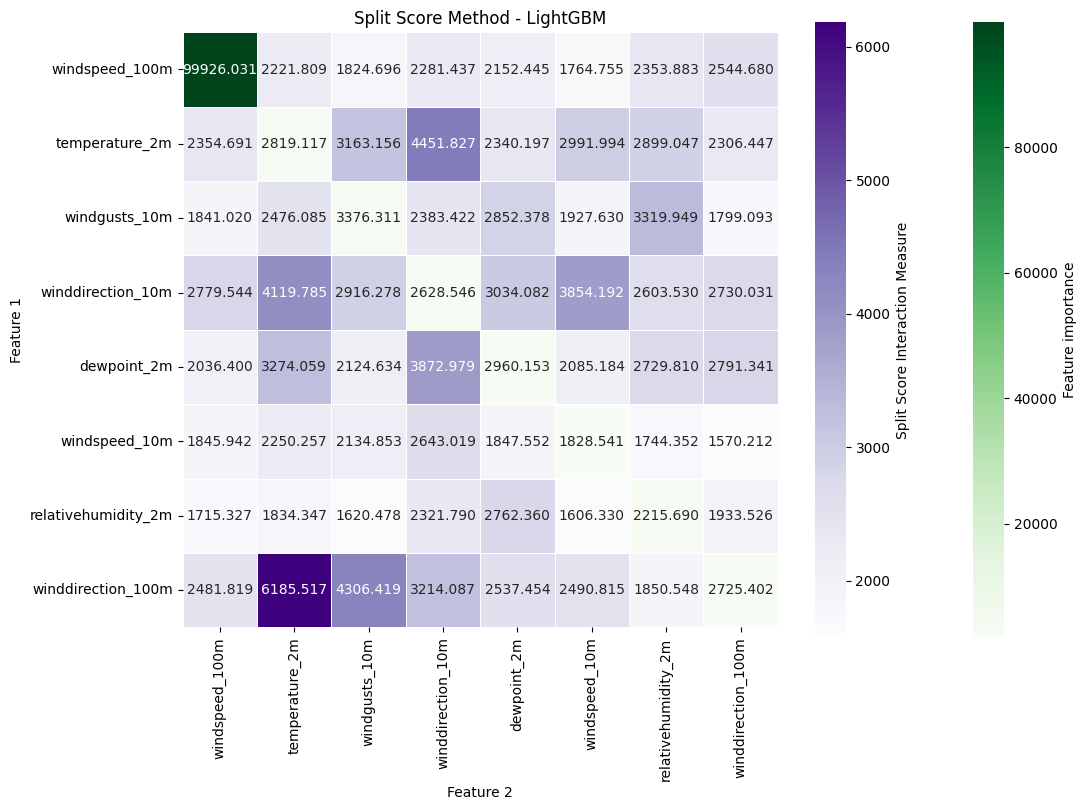

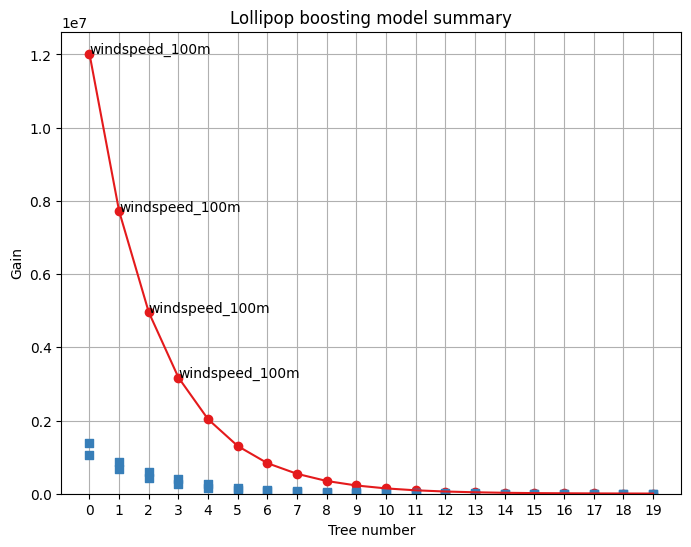

In [56]:
# This is a method proposed by Karbowiak and Biecek. It is suitable for gradient-boosted trees models and used their structure for extracting interactions. Namely, it compares split scores (gain, cover) of consecutive nodes in trees.
from artemis.interactions_methods.model_specific import SplitScoreMethod

split_score = SplitScoreMethod()
split_score.fit(lgbm_model, show_progress=True, interaction_selected_metric = "mean_gain")

split_score.plot('heatmap', title='Split Score Method - LightGBM', figsize=(12, 10))
split_score.plot('lollipop', label_threshold = 0.2)